# Mentoría Ciencia de datos aplicada a la predicción de licencias médicas y comportamiento de los colaboradores

# Trabajo Práctico 2: Análisis Exploratorio y Curación

Trabajar con el csv denominado data.csv y resolver las siguientes consignas:

1) Analisis e imputación de valores faltantes, nulos y/o ruidosos en las columnas relevantes del dataset.

    1.A) ¿Existe alguna relación entre los datos faltantes? Usar la librería missingno para resolver esta consigna. 

    1.B) Realizar la imputación de aquellas columnas con datos faltantes, justificar el método. 
    
    1.C) Trabajar con las columnas dias_aprobados y dias_solicitados, observar si existe coherencia en las mismas y datos nulos o ruidosos que deban imputar.

2) Observar si existen outliers en las columnas relevantes. Tomar una decisión con los mismos y justificarla.

3) Trabajar con las columnas categóricas del dataset, decidir si corresponde realizar algún reagrupamiento, considerando su frecuencia. Ayuda: tener en cuenta la presencia de caracteres especiales y/o espacios vacíos en la columna diagnostico.

    3.1) Para el reagrupamiento de la columna diagnostico, ayudarse de la base externa, https://icdcode.info/espanol/cie-10/codigos.html que contiene la clasificación y agrupación de diagnosticos a nivel internacional. Les dejamos el csv de la misma y una breve explicación de como utilizarla https://raw.githubusercontent.com/verasativa/CIE-10/master/cie-10.csv. Para la union de esta base externa con el dataframe de licencias, deberan usar el data_key.csv que le adjuntamos en este TP.

4) A partir de la columna fecha_creacion, generar dos columnas extras temporales utilizando las escalas temporales que consideren adecuadas, por ejemplo: día, semana, quincena, mes, trimestre o semestre. Pueden utilizar la función resample de pandas.

5) Generar y guardar el nuevo dataset con todas las tranformaciones realizadas, el cual sera el input de los siguientes tp de aprendizaje supervisado/no supervisado.



## Carga del dataset

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

url = 'https://raw.githubusercontent.com/MentoriaDiploDatos/Presentacion/main/data.csv'
df = pd.read_csv(url, sep=';')

In [2]:
df.head(2)

,numero_licencia,fecha_creacion,dispositivo_acceso,dias_solicitados,fecha_inicio,fecha_fin,diagnostico,id_diagnostico,id_usuario,fecha_nacimiento,genero,tipo_licencia,estado_civil,dias_aprobados,decision_medica,id_auditor,motivo_rechazo,categoria_diagnostico
0,1,2021-01-01 00:10:10.418,APP,2.0,2021-01-01,2021-01-01,EFECTOS ADVERSOS DE VACUNAS VIRALES,NaN,15508,1979-11-28,FEMALE,Médica,OTHER,2.0,EDITAR_Y_APROBAR,14721.0,NaN,NaN
1,105,2021-01-02 14:14:20.330,APP,2.0,2021-01-02,2021-01-03,EFECTOS ADVERSOS DE VACUNAS VIRALES,NaN,15508,1979-11-08,FEMALE,Médica,OTHER,2.0,EDITAR_Y_APROBAR,14721.0,NaN,NaN


In [3]:
url_key = 'https://raw.githubusercontent.com/MentoriaDiploDatos/Exploracion-Y-Curacion/main/data_key.csv'
keys = pd.read_csv(url_key, sep=';')

In [4]:
keys.sample(2)

,numero_licencia,key
70091,168590,J02
167565,295413,R05


## Utilizacion de la base CIE.10 de agrupadores de diagnosticos

In [4]:
df_cod =pd.read_csv('https://raw.githubusercontent.com/verasativa/CIE-10/master/cie-10.csv')

Veamos el diagnostico correspondiente a la key A02, en este caso se corresponde con la descripcion Otras infecciones debidas a Salmonella.

In [6]:
df_cod[df_cod['code'] =='A02']

,code,code_0,code_1,code_2,code_3,code_4,description,level,source
375,A02,A00-B99,A00-A09,NaN,NaN,NaN,Otras infecciones debidas a Salmonella,2,icdcode.info


A partir de los grupos y subgrupos que figuran en las columnas code_0, code_1 y siguientes, podemos obtener las descripciones correspondientes.

Observamos que el significado del grupo A00-B99, al que pertenece A02, es Ciertas enfermedades infecciosas y parasitarias (observar que el level es 0)

In [6]:
df_cod[df_cod['code'] == df_cod[df_cod['code'] =='A02']['code_0'].values[0]]

,code,code_0,code_1,code_2,code_3,code_4,description,level,source
0,A00-B99,NaN,NaN,NaN,NaN,NaN,Ciertas enfermedades infecciosas y parasitarias,0,icdcode.info


Tambien podemos obtener el grupo siguiente al que pertenece este diagnostico, de la siguiente manera (observar que el level es 1).

In [9]:

df_cod[df_cod['code'] == df_cod[df_cod['code'] =='A02']['code_1'].values[0]]

,code,code_0,code_1,code_2,code_3,code_4,description,level,source
64,A00-A09,A00-B99,NaN,NaN,NaN,NaN,Enfermedades infecciosas intestinales,1,icdcode.info


Un ejemplo de como podrian ir incorporando las descripciones de grupos y subgrupos a cada diagnostico individual, es haciendo joins del dataframe con si mismo utilizando como clave los codigos que corresponden.

In [5]:
df_complete_cod = df_cod.merge(df_cod[['code','description']], how='left',left_on='code_0',right_on='code')

In [6]:
df_complete_cod.rename(columns={'code_x':'code', 'description_x':'description','description_y':'description_group_level0'},inplace=True)
df_complete_cod.drop(columns=['code_y'],inplace=True)

In [7]:
df_complete_cod[df_complete_cod['code'] =='A02']

,code,code_0,code_1,code_2,code_3,code_4,description,level,source,description_group_level0
375,A02,A00-B99,A00-A09,NaN,NaN,NaN,Otras infecciones debidas a Salmonella,2,icdcode.info,Ciertas enfermedades infecciosas y parasitarias


## Resolución

### 1) Análisis e imputación de valores faltantes, nulos y/o ruidosos

Se considera el dataset con la selección de columnas relevantes que se había seleccionado en el trabajo práctico n°1.

In [8]:
# se crea un dataset con las columnas relevantes
relevant_columns = ['numero_licencia', 'fecha_creacion', 'dias_solicitados', 'fecha_inicio', 'fecha_fin', 'diagnostico',
                    'id_diagnostico', 'fecha_nacimiento', 'genero', 'tipo_licencia', 'estado_civil', 
                    'dias_aprobados', 'decision_medica', 'id_auditor', 'motivo_rechazo', 'categoria_diagnostico']
relev_df = df[relevant_columns].copy()
relev_df.head()

,numero_licencia,fecha_creacion,dias_solicitados,fecha_inicio,fecha_fin,diagnostico,id_diagnostico,fecha_nacimiento,genero,tipo_licencia,estado_civil,dias_aprobados,decision_medica,id_auditor,motivo_rechazo,categoria_diagnostico
0,1,2021-01-01 00:10:10.418,2.0,2021-01-01,2021-01-01,EFECTOS ADVERSOS DE VACUNAS VIRALES,NaN,1979-11-28,FEMALE,Médica,OTHER,2.0,EDITAR_Y_APROBAR,14721.0,NaN,NaN
1,105,2021-01-02 14:14:20.330,2.0,2021-01-02,2021-01-03,EFECTOS ADVERSOS DE VACUNAS VIRALES,NaN,1979-11-08,FEMALE,Médica,OTHER,2.0,EDITAR_Y_APROBAR,14721.0,NaN,NaN
2,113806,2021-08-26 09:32:09.396,1.0,2021-08-26,2021-08-26,COLELITIASIS,NaN,1980-10-25,FEMALE,Médica,SINGLE,0.0,RECHAZAR,14721.0,NaN,NaN
3,333787,2022-08-03 20:29:25.519,1.0,2022-08-03,2022-08-03,LUMBAGO NO ESPECIFICADO. CONTRACTURA DORSAL IN...,22.0,1986-12-01,MALE,Médica,SINGLE,1.0,EDITAR_Y_APROBAR,14721.0,Se aprueba la licencia,TRAUMATOLOGIA Y ORTOPEDIA
4,428763,2022-12-26 12:41:18.734,2.0,2022-12-26,2022-12-27,COLITIS Y GASTROENTERITIS NO INFECCIOSAS,6.0,1986-12-21,MALE,Médica,SINGLE,2.0,EDITAR_Y_APROBAR,14721.0,Se aprueba la licencia,GASTROINTESTINAL


#### a. Valores faltantes, nulos y/o ruidosos

Se explora el dataset para buscar **valores faltantes** (datos que no se encuentran presentes en una variable o columna determinada, ya sea porque no se registraron o porque se perdieron), y para buscar **valores ruidosos** (datos sospechosos o posiblemente erróneos).

In [9]:
# se identifican los valores nulos (None o NaN)
relev_df.isnull().sum()

numero_licencia               0
fecha_creacion                0
dias_solicitados           6035
fecha_inicio                  0
fecha_fin                     1
diagnostico                   0
id_diagnostico           157021
fecha_nacimiento              0
genero                        0
tipo_licencia                 0
estado_civil                  0
dias_aprobados             3078
decision_medica            3078
id_auditor                 3079
motivo_rechazo           242267
categoria_diagnostico    158928
dtype: int64

<Axes: >

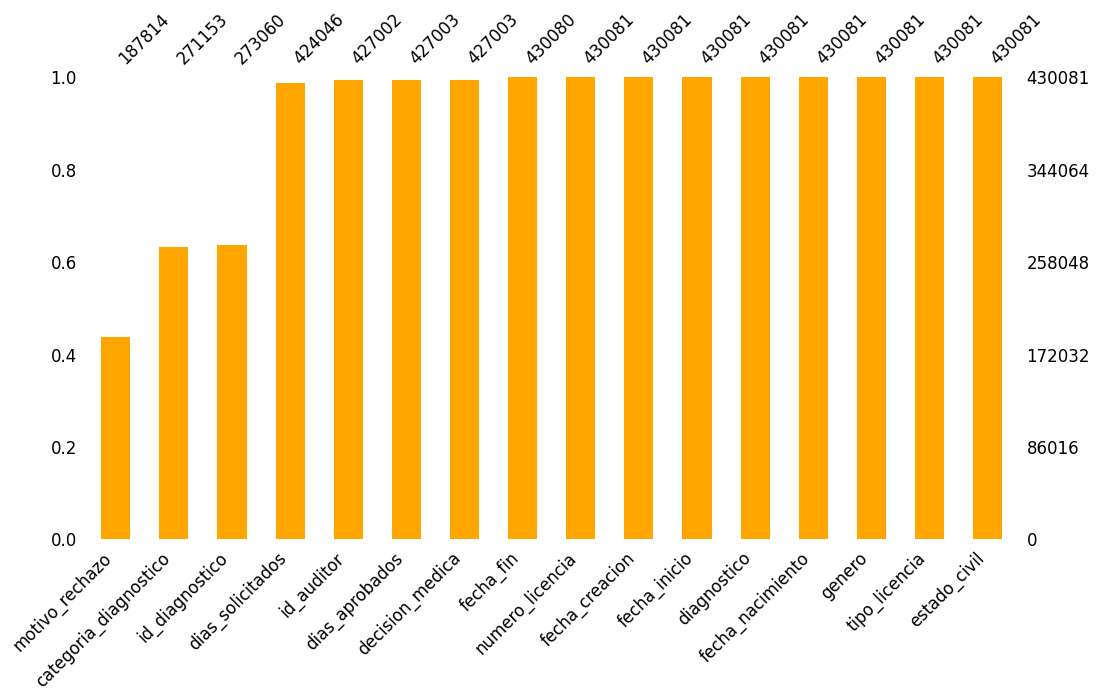

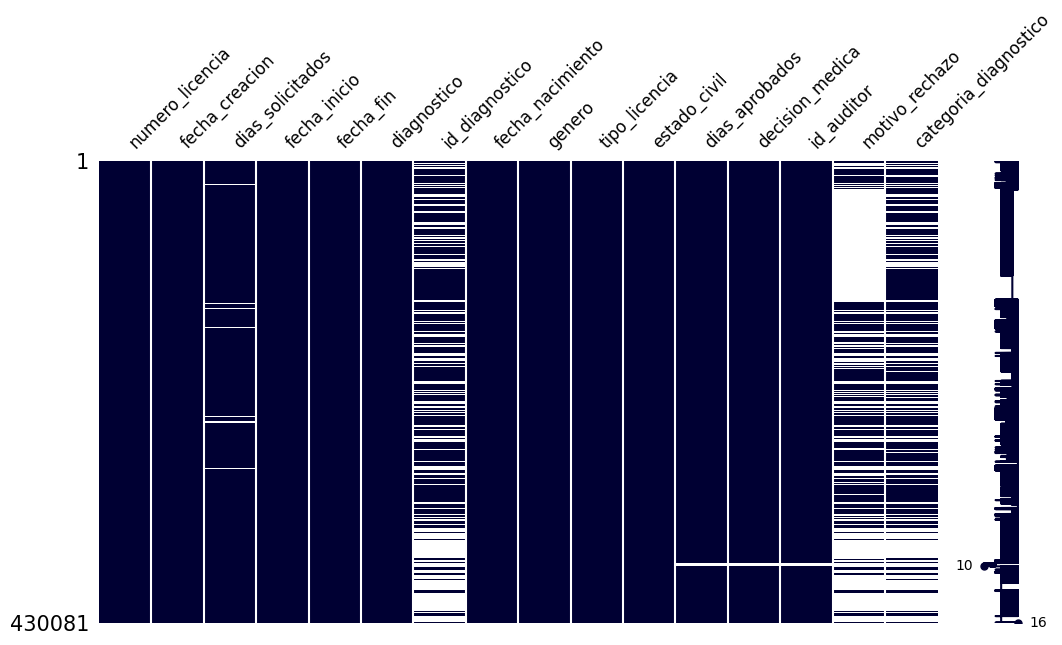

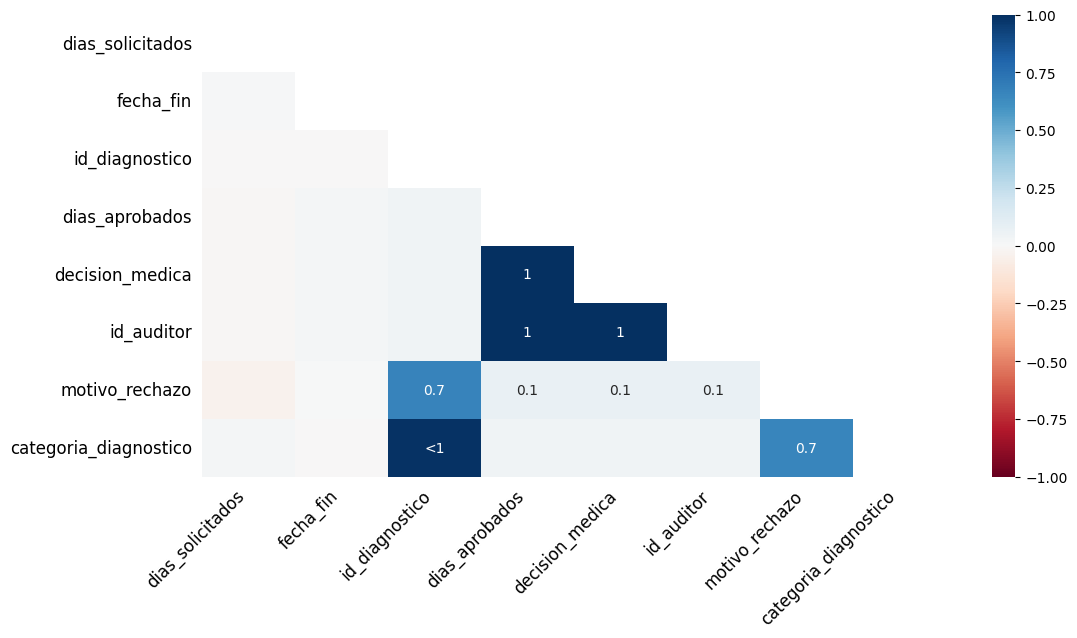

In [11]:
import missingno as msno

msno.bar(relev_df,figsize=(12, 6), sort="ascending",fontsize=12, color='orange')
msno.matrix(relev_df,figsize=(12, 6), fontsize=12, color=[0,0,0.2])
msno.heatmap(relev_df,figsize=(12, 6), fontsize=12)

El uso de la librería *missingno* nos revela valores faltantes en las siguientes columnas:

- fecha_fin
- decision_medica
- dias_aprobados
- id_auditor
- dias_solicitados
- id_diagnostico
- categoria_diagnostico
- motivo_rechazo

##### i) Registros sin auditar

El análisis previo nos permite identificar un conjunto de variables con valores faltantes con una correlación total (corr=1). Estas variables son:

 - id_auditor
 - decision_medica
 - dias_aprobados

 Se observa que en el caso que un valor falta en una columna, falta en las otras; esto podría deberse a que los tres datos se completan cuando la solicitud es auditada; la ausencia de valores podría indicar que los registros no fueron auditados.

 > Nota: se confirmó con el proveedor del conjunto de datos que algunas solicitudes pueden ser aprobadas automáticamente sin ser auditadas al cumplir ciertos criterios; esto explicaría los valores faltantes en estas tres columnas.

 La solución propuesta es eliminar las filas sin auditar, ya que los valores faltantes no superan el 1% del dataset y no contribuyen en forma directa a resolver la hipótesis planteada inicialmente en el trabajo práctico n°1.

##### ii) Registros sin diagnóstico

También es posible identificar un segundo conjunto de variables con valores faltantes con una correlación alta (corr>0.7). Estas variables son:

 - id_diagnostico
 - categoria_diagnostico
 - motivo_rechazo

En este caso se observa que la ausencia de valores en estas columnas se ubica entre un 40% y un 60% del total de observaciones.

Por el alto grado de correlación, en particular entre el par *id_diagnostico* y *categoria_diagnostico*, se descarta que se trate de valores faltantes completamenta al azar (MCAR). 

Para resolver los faltantes en el par *id_diagnostico* y *categoria_diagnostico* se propone imputar dichos valores considerando el valor existente en la columna *diagnostico* e intentando recuperar los valores faltantes cruzando esa columna con los datos existentes en la base del CIE-10.

En el caso del campo *motivo_rechazo*, se puede asignar a los valores faltantes un valor arbitrario fuera del rango actual de valores de la variable (por ej, *NO SE REGISTRA MOTIVO DE RECHAZO*)

##### iii) Registros sin fecha de fin

Por tratarse de un solo registro en todo el dataset, se limita el análisis de los posibles motivos de la falta del data como tambián el esfuerzo por imputarlo usando alguna técnica; en cambio, se decide simplemente descartar el registro.

##### iv) Registros sin días solicitados

 > Nota: se confirmó con el proveedor del conjunto de datos que por la estructura de la base de datos y las consultas que se realizaron para extraer el dataset, es posible que los datos relacionados a dias solicitados y dias aprobados no sean del todo consistentes; según se pudo averiguar por cada solicitud de licencia se crea un registro en una tabla de solicitudes en la base de datos, pero luego los datos dias_solicitados y dias_aprobados se van modificando a lo largo de un flujo de trabajo de seguimiento y auditoría de la solicitud; como los datos recuperados por la consulta parecieran corresponder a los datos existentes en la última actuación realizada sobre la solicitud, es posible que los datos finalmente exportados por la consulta a este dataset no contengan la información que refleje la realidad de la decisión tomada sobre la misma.
 
 > En particular, se pudo averiguar que los dias solicitados faltantes corresponden a un caso particular de licencias médicas: las licencias médicas por hospitalización, las cuales son aprobadas sin ser solicitadas por el trabajador.

Como se muestra a continuación, se observa una coincidencia en la cantidad de valores nulos en la columna *días_solicitados* y la cantidad de valores "Médica por Hospitalización" en la columna *tipo_licencia*

In [10]:
print("Cant. de registros con valores nulos en dias_solicitados: \t\t\t\t", relev_df['dias_solicitados'].isnull().value_counts()[True])
print("Cant. de registros con valores 'Médica por hospitalización' en tipo_licencia: \t\t", relev_df['tipo_licencia'].value_counts()['Médica por Hospitalización'])

Cant. de registros con valores nulos en dias_solicitados: 				 6035
Cant. de registros con valores 'Médica por hospitalización' en tipo_licencia: 		 6034


Luego se puede comprobar que son exactamente los mismos registros a excepción de uno. El registro que no cumple ambas condiciones será analizado a continuación.

In [11]:
condicion_dias_solicitados_x_hospitalizacion = (relev_df['dias_solicitados'].isnull()) & (relev_df['tipo_licencia']=='Médica por Hospitalización')
relev_df[condicion_dias_solicitados_x_hospitalizacion]

,numero_licencia,fecha_creacion,dias_solicitados,fecha_inicio,fecha_fin,diagnostico,id_diagnostico,fecha_nacimiento,genero,tipo_licencia,estado_civil,dias_aprobados,decision_medica,id_auditor,motivo_rechazo,categoria_diagnostico
308,1804,2021-01-18 12:29:24.615,NaN,2021-01-18,2021-01-20,COVID SOSPECHOSO,NaN,1971-10-31,MALE,Médica por Hospitalización,MARRIED,3.0,EDITAR_Y_APROBAR,14721.0,NaN,NaN
591,5496,2021-02-15 10:13:29.838,NaN,2021-02-14,2021-03-06,COVID POSITIVO,NaN,1963-07-22,MALE,Médica por Hospitalización,OTHER,21.0,EDITAR_Y_APROBAR,14721.0,NaN,NaN
1044,7415,2021-02-24 10:39:45.911,NaN,2021-02-24,2021-03-06,COVID POSITIVO,NaN,1985-09-02,FEMALE,Médica por Hospitalización,OTHER,11.0,EDITAR_Y_APROBAR,14721.0,NaN,NaN
1106,7802,2021-02-25 15:48:53.205,NaN,2021-02-24,2021-02-24,COVID POSITIVO,NaN,1977-02-25,FEMALE,Médica por Hospitalización,SINGLE,0.0,RECHAZAR,14721.0,NaN,NaN
11724,21382,2021-03-31 15:35:26.264,NaN,2021-03-31,2021-03-31,COLECISTECTOMIA,NaN,1989-11-16,MALE,Médica por Hospitalización,SINGLE,1.0,EDITAR_Y_APROBAR,6233.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422223,191777,2021-12-10 12:12:36.050,NaN,2021-11-30,2021-12-09,COLECISTECTOMIA,97.0,1985-03-31,MALE,Médica por Hospitalización,MARRIED,10.0,EDITAR_Y_APROBAR,1056.0,Se aprueba la licencia,NaN
423635,1297,2021-01-13 17:17:20.919,NaN,2021-01-09,2021-01-09,DOLOR ABDOMINAL Y PELVICO,NaN,1966-08-28,FEMALE,Médica por Hospitalización,OTHER,0.0,RECHAZAR,11625.0,NaN,NaN
429686,1021,2021-01-11 16:08:57.010,NaN,2021-01-05,2021-01-24,INFARTO CEREBRAL (ACV),NaN,1960-10-19,MALE,Médica por Hospitalización,MARRIED,20.0,EDITAR_Y_APROBAR,4502.0,NaN,NaN
429692,213461,2022-01-26 09:38:27.688,NaN,2022-01-13,2022-02-04,Condición de salud posterior a COVID-19 (Sindr...,68.0,1963-10-24,MALE,Médica por Hospitalización,OTHER,23.0,EDITAR_Y_APROBAR,4502.0,Diagnostico no valido,INFECCIONES


De los registros con valores nulos en la columna *dias_solicitados* casi todos corresponden a licencias médicas por hospitalización como pudo comprobarse; sin embargo un caso corresponde a otra situación que se presenta a continuación. 

In [12]:
relev_df[(relev_df['dias_solicitados'].isnull()) & ~(relev_df['tipo_licencia']=='Médica por Hospitalización')]

,numero_licencia,fecha_creacion,dias_solicitados,fecha_inicio,fecha_fin,diagnostico,id_diagnostico,fecha_nacimiento,genero,tipo_licencia,estado_civil,dias_aprobados,decision_medica,id_auditor,motivo_rechazo,categoria_diagnostico
22045,15249,2021-03-18 08:42:31.440,NaN,2021-03-17,2021-03-17,TUMOR MALIGNO DE CERBRO,NaN,1973-03-23,FEMALE,Médica,OTHER,0.0,RECHAZAR,1027.0,NaN,NaN


Si bien no hay suficiente información para determinar a qué caso corresponde este registro, al ser un solo registro y estar rechazado no afecta el análisis de la hipótesis. hipótesis 

 Los valores faltantes rondan el 1.5% del dataset, sin embargo no tienen impacto directo sobre la hipótesis planteada inicialmente en el trabajo práctico n°1, ya que estos registros no corresponden a licencias médicas solicitadas por los trabajadores sino a licencias otorgadas automáticamente por hospitalización o al caso particular que figura rechazazo, por lo que se propone eliminar estas filas.

##### v) Registros con géneros ruidosos 

Este atributo presenta los siguientes tres valores

 - *FEMALE*
 - *MALE*
 - *OTHER*

El valor *OTHER* presenta una frecuencia tan baja de ocurrencias que será considerado ruidoso.
Se propone imputar los valores *OTHER* siguiendo las frecuencias relativas de los otros dos valores.

In [8]:
generos_abs_freq = pd.crosstab(index=relev_df["genero"], columns="count")
generos_rel_freq = generos_abs_freq/generos_abs_freq.sum()
generos_rel_freq


col_0,count
genero,
FEMALE,0.775884
MALE,0.224021
OTHER,0.000095


#### b. Curación del conjunto de datos

##### i.- Descarte de filas sin auditoría

Para el caso de los registros sin auditar, se descartan los registros que tengan faltante el dato *id_auditor*.

In [13]:
#Se quitan todos los registros que no pasaron por auditoria
relev_df = relev_df.dropna(subset=['id_auditor'])

##### ii.- Imputación de valores faltantes en diagnósticos

En el caso de la columna *id_diagnostico*, aparecen valores nulos en registros con *diagnostico* registrado; es posible, por lo tanto, imputar el valor de *id_diagnostico* existente en los diagnósticos que si tienen el dato cargado a los registros que no lo tienen.

Sin embargo, se observa que algunos diagnósticos aparecen duplicados debido a caracteres extraños en el dato, por lo que antes de la imputación será necesario limpiar el campo *descripcion* para poder identificar correctamente los *id_diagnostico* existentes. 

In [14]:
# limpieza de espacios en blanco iniciales y finales, y espacios ubicados luego de comas (,)
relev_df['diagnostico']=relev_df['diagnostico'].str.strip()
relev_df['diagnostico']=relev_df['diagnostico'].str.replace(', ', ',')

In [15]:
# creacion de grupos por diagnostico y posterior llenado de id_diagnostico a partir de valores existentes
aux_groups = relev_df.groupby('diagnostico')

relev_df['id_diagnostico'] = aux_groups['id_diagnostico'].transform(lambda s: 'SIN VALOR' if 
    pd.isnull(s).all() == True else s.loc[s.first_valid_index()])
relev_df['categoria_diagnostico'] = aux_groups['categoria_diagnostico'].transform(lambda s: 'SIN VALOR' if 
    pd.isnull(s).all() == True else s.loc[s.first_valid_index()])

##### iii.- Descarte de filas sin fecha fin

Para el caso del registro con fecha de fin faltante, se descarta el registro.

In [16]:
#Se quitan todos los registros que no tienen fecha_fin
relev_df = relev_df.dropna(subset=['fecha_fin'])

##### iv.- Imputación de días solicitados faltantes

Para el caso de los registros sin días solicitados, si bien se pudo detectar que corresponden a licencias médicas por hospitalización y podrían descartarse ya que no afectan el análisis sobre la hipótesis planteada, se conservarán y se imputarán con la cantidad de días aprobados, entendiendo que pueden aportar información que difiera a la de las licencias médicas (p.ej. diagnósticos).

In [17]:
# nos valemos del numero_licencia para identificar los registros buscados
records_con_dias_solicitados_null=relev_df[relev_df['dias_solicitados'].isnull()]['numero_licencia']

In [18]:
# se imputan los valores de 'dias_solicitados' que estan en nulo con los valores 'dias_aprobados'
relev_df['dias_solicitados'].mask(relev_df['dias_solicitados'].isnull(), relev_df['dias_aprobados'], inplace=True)

# se comprueba que los registros detectados con dias solicitados en nulo se imputaron con los dias aprobados
relev_df[relev_df['numero_licencia'].isin(records_con_dias_solicitados_null)][['dias_solicitados','dias_aprobados']]

,dias_solicitados,dias_aprobados
308,3.0,3.0
591,21.0,21.0
1044,11.0,11.0
1106,0.0,0.0
11724,1.0,1.0
...,...,...
422223,10.0,10.0
423635,0.0,0.0
429686,20.0,20.0
429692,23.0,23.0


##### v.- Imputación de géneros ruidosos

Para el caso del atributo *genero*, se imputan los valores *['OTHER']* con valores *['FEMALE', 'MALE']* siguiendo las probabilidades de ocurrencia de ambos valores.

In [14]:
import numpy as np

# previamente se habian obtenido las frecuencias relativas de cada genero; ahora se usaran como probabilidad en la funcion prob_gender()
aux_freqs = generos_rel_freq.to_numpy().reshape(1,-1).flatten()

# genera valores ['FEMALE', 'MALE'] siguiendo las probabilidades relativas obtenidas previamente
def prob_gender():
    return np.random.choice(
                a = ['FEMALE', 'MALE'],
                p = [aux_freqs[0], 1 - aux_freqs[0]]
            )

# se imputan los valores de genero ['OTHER'] con los valores ['FEMALE', 'MALE'] siguiendo las probabilidades relativas obtenidas previamente
relev_df['genero'].mask(relev_df['genero'] == 'OTHER', prob_gender(), inplace=True)


##### vi.- Estado del dataset luego de las transformaciones

Finalmente, luego de descartar registros con valores nulos e imputar otros, se presenta el estado actual del dataset en cuanto a valores nulos y faltantes

In [19]:
relev_df.isnull().sum()

numero_licencia               0
fecha_creacion                0
dias_solicitados              0
fecha_inicio                  0
fecha_fin                     0
diagnostico                   0
id_diagnostico                0
fecha_nacimiento              0
genero                        0
tipo_licencia                 0
estado_civil                  0
dias_aprobados                0
decision_medica               0
id_auditor                    0
motivo_rechazo           239188
categoria_diagnostico         0
dtype: int64

#### c. Análisis de atributos *dias_solicitados* y *dias_aprobados*

El tratamiento a estos dos campos se inició en los incisos anteriores y se completará en este punto el análisis sobre la consistencia de los datos.

##### i.- Valores faltantes

En cuanto al atributo *dias_aprobados* se habáan detectado valores faltantes (ver inc. 1.a.i), los cuales fueron descartados (ver inc. 1.b.i).
En cuanto al atributo *dias_solicitados* se detectaron valores faltantes (ver inc. 1.a.iv), pero en este caso fueron los valores fueron imputados utilizando el valor de *dias_aprobados* (ver inc. 1.b.iv).


##### ii.- Valores ruidosos

Este análisis se realizará a continuación en el punto 2).

##### iii.- Consistencia entre *dias_solicitados* y *dias_aprobados*

Se encontró que los valores presentan ciertas inconsistencias, particularmente en relación a los atributos *fecha_inicio* y *fecha_fin*.

En relación al atributo *dias_solicitados* es posible que el trabajador solicite un número de días que luego no coincida con los aprobados, o incluso, que como se vio en el caso de las licencias por internación, directamente no solicite días.

En cambio, en el caso de *dias_aprobados* se hubiera esperado una relación entre la cantidad de dias entre *fecha_inicio* y *fecha_fin* y el valor de días efectivamente aprobados. Sin embargo, según se pudo constatar anteriormente (ver inc. 1.a.iv), es posible que el dataset no incluya el valor real de este atributo.

In [16]:
cols = ['id_auditor', 'fecha_inicio', 'fecha_fin', 'dias_solicitados', 'dias_aprobados']
relev_df[cols].sample(20)

,id_auditor,fecha_inicio,fecha_fin,dias_solicitados,dias_aprobados
389253,47151.0,2021-07-08,2021-07-14,7.0,10.0
526,14721.0,2022-07-04,2022-07-05,2.0,1.0
114926,0.0,2022-07-15,2022-07-15,2.0,2.0
56797,0.0,2022-10-13,2022-10-14,2.0,2.0
324453,69816.0,2022-10-27,2022-10-28,2.0,2.0
416194,905.0,2021-11-03,2021-11-03,5.0,6.0
385430,62294.0,2022-02-26,2022-02-26,30.0,0.0
215619,3846.0,2022-12-19,2022-12-20,2.0,2.0
188725,14240.0,2022-11-03,2022-11-04,2.0,2.0
85780,0.0,2021-12-15,2021-12-16,3.0,3.0


### 2) Análisis de outliers

Se buscan valores atípicos en las columnas seleccionadas mediante exploración visual.

### a) Variables numéricas de tipo fecha

Entre las variables numéricas se analizarán primeramente las variables de tipo fecha: *fecha_creacion*, *fecha_inicio*, *fecha_fin* y *fecha_nacimiento*

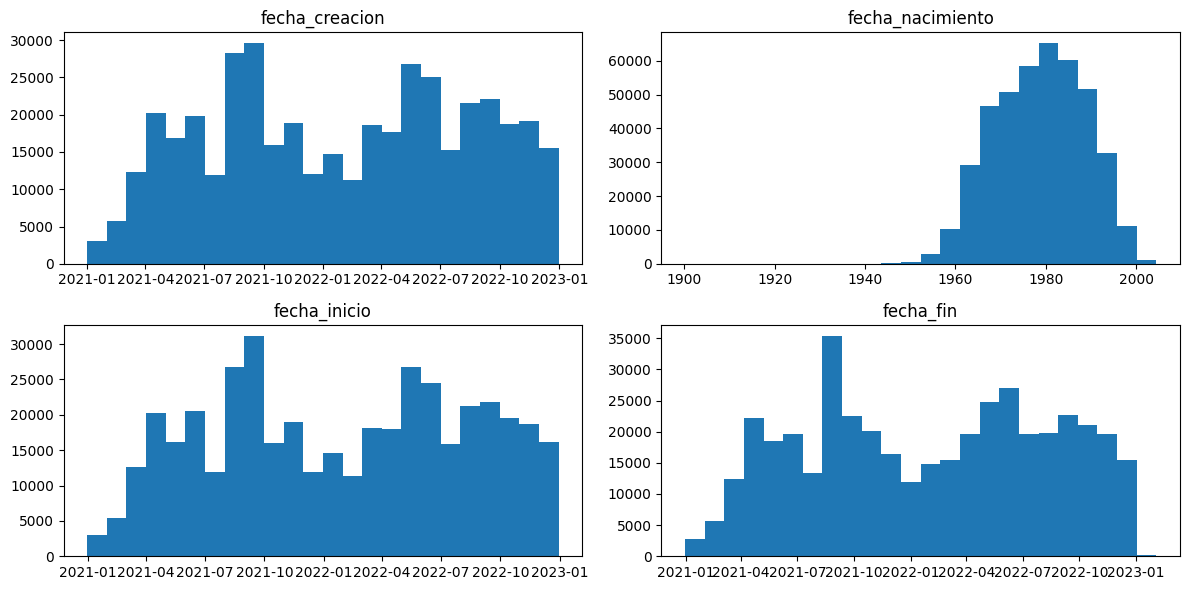

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

pd.plotting.register_matplotlib_converters()

relev_df['fecha_creacion'] = pd.to_datetime(relev_df['fecha_creacion'])
relev_df['fecha_inicio'] = pd.to_datetime(relev_df['fecha_inicio'])
relev_df['fecha_fin'] = pd.to_datetime(relev_df['fecha_fin'])
relev_df['fecha_nacimiento'] = pd.to_datetime(relev_df['fecha_nacimiento'])

figure, axis = plt.subplots(2, 2, figsize=(12, 6))

axis[0, 0].hist(relev_df['fecha_creacion'], bins=24)
axis[0, 0].set_title("fecha_creacion")

axis[0, 1].hist(relev_df['fecha_nacimiento'], bins=24)
axis[0, 1].set_title("fecha_nacimiento")

axis[1, 0].hist(relev_df['fecha_inicio'], bins=24)
axis[1, 0].set_title("fecha_inicio")

axis[1, 1].hist(relev_df['fecha_fin'], bins=24)
axis[1, 1].set_title("fecha_fin")

figure.tight_layout()

#### i) fecha_creacion

Se conocía de antemano que el dataset correspondía a solicitudes realizadas durante un período de dos años, y esto se comprueba en el histograma.

> No se detectan valores atípicos

#### ii) fecha_nacimiento

Este campo debería reflejar la fecha de nacimiento de los solicitantes al momento de realizar la solicitud de licencia; si se considera que los solicitantes son trabajadores que cumplen con las leyes argentinas, el rango de edad de los solicitantes incluidos en el dataset deberían tener una edad entre 18 y 65 años, es decir una fecha de nacimiento posterior a enero de 1955 (65 años antes a la menor fecha de creación del dataset), y anterior a diciembre de 2004 (18 años antes a la mayor fecha de creación del dataset).

También se considera que en el punto 2.a) se realizó una transformación de la variable (conversión a tipo datetime), pero como también pudo comprobarse en el punto 1) no hay valores faltantes en la columna, por lo tanto no hay riesgo de que la transformación haya introducido valores atípicos.

Se comprueba observando valores mínimos y máximos y presentándolos de manera ordenada que hay valores atípicos.

> Se detectan valores atípicos anteriores a la fecha de nacimiento más antigua posible.

Se recomienda **investigar con el proveedor del dataset si existe alguna otro atributo en la base de datos (como por ejemplo el número de documento del solicitante) que permita inferir la fecha de nacimiento**. Si no es así, se recomienda **anular los valores para el dato *fecha_nacimiento* y luego imputarles un valor utilizando algún estadístico (moda o mediana)**.

In [18]:
print("Valor mínimo: ", relev_df['fecha_nacimiento'].min(), " , Valor máximo: ", relev_df['fecha_nacimiento'].max())
relev_df['fecha_nacimiento'].sort_values()

Valor mínimo:  1900-02-16 00:00:00  , Valor máximo:  2004-07-01 00:00:00


144059   1900-02-16
328115   1900-02-20
281960   1900-02-24
207866   1900-03-05
194687   1900-03-10
            ...    
319791   2003-11-14
177287   2003-11-26
422354   2003-11-29
198063   2004-06-19
137383   2004-07-01
Name: fecha_nacimiento, Length: 420968, dtype: datetime64[ns]

#### iii) fecha_inicio

Este campo debería reflejar el inicio de las licencias médicas aprobadas; si se considera que las solicitudes del dataset tienen fecha de creación a partir de enero de 2021 y hasta diciembre de 2022, las fechas de inicio de licencias aprobadas deberían ser cercanas a las fechas de creación.
Se entiende que la fecha de inicio de una licencia puede ser anterior a la fecha de creación de la solicitud (es posible que una licencia médica se haya aprobado usando un canal de comunicación diferente al sistema de gestión de licencias, y que la carga de la misma se haya realizado a posteriori). Aún así, y dando un período de seguridad de seis meses entre el inicio de la licencia y el registro de la misma, se observan fechas de inicio que no corresponden a los valores esperados.

También se considera que en el punto 2.a) se realizó una transformación de la variable (conversión a tipo datetime), pero como también pudo comprobarse en el punto 31) no hay valores faltantes en la columna, por lo tanto no hay riesgo de que la transformación haya introducido valores atípicos.

Esto se comprueba observando valores mínimos y máximos y presentándolos de manera ordenada.

> Se detectan valores atípicos anteriores a la fecha de creación más antigua (aún considerando el período de seguridad de seis meses)

Se recomienda **investigar con el proveedor del dataset si las fechas de inicio de licencias detectadas como valores atípicos corresponden a casos reales o no**. Si no es así, se recomienda **anular los valores para el dato *fecha_inicio* y luego imputarles el valor de fecha de creacion**

In [19]:
print("Valor mínimo: ", relev_df['fecha_inicio'].min(), " , Valor máximo: ", relev_df['fecha_inicio'].max())
relev_df['fecha_inicio'].sort_values()

Valor mínimo:  2020-12-31 00:00:00  , Valor máximo:  2022-12-30 00:00:00


26577    2020-12-31
26582    2020-12-31
10778    2020-12-31
0        2021-01-01
10841    2021-01-01
            ...    
272260   2022-12-30
209276   2022-12-30
116147   2022-12-30
124172   2022-12-30
198231   2022-12-30
Name: fecha_inicio, Length: 420968, dtype: datetime64[ns]

#### iv) fecha_fin

Este campo debería reflejar el fin de las licencias médicas aprobadas. 

Se desconoce si existe un límite máximo en la cantidad de días de licencia que pueden otorgarse; también se desconoce si se registran solicitudes de licencias que ya hayan finalizado (fecha de creación mayor a la fecha de fin de la misma); aún así, y tal como se analizó para el dato *fecha_inicio*, se considera que si las solicitudes del dataset tienen fecha de creación a partir de enero de 2021 y hasta diciembre de 2022, entonces las fechas de fin de licencias aprobadas deberían ser cercanas a las fechas de creación.
Si se mantiene el supuesto del punto anterior que la fecha de inicio de una licencia puede ser anterior a la fecha de creación de la solicitud con un período de seguridad de seis meses entre el inicio de la licencia y el registro de la misma, entonces las fechas de finalización también deberían cumplir ese criterio.

También se considera que en el punto 2.a) se realizó una transformación de la variable (conversión a tipo datetime); pero, aunque hay un solo valor faltante en la columna como pudo verse en el punto 1), la conversión aplicada no modificó el valor nulo, por lo tanto no hay riesgo de que la transformación haya introducido valores atípicos.

No obstante, y a pesar de todas las consideraciones realizadas, se observan fechas de fin que no corresponden a los valores esperados.

Esto se comprueba observando valores mínimos y máximos y presentándolos de manera ordenada.

> Se detectan valores atípicos anteriores a la fecha de creación más antigua

Se recomienda **investigar con el proveedor del dataset si las fechas de inicio de licencias detectadas como valores atípicos corresponden a casos reales o no**. Si no es así, se recomienda **anular los valores para el dato *fecha_fin* y luego imputarles el valor de fecha de inicio sumados los días aprobados**

In [20]:
print("Valor mínimo: ", relev_df['fecha_fin'].dropna().min(), " , Valor máximo: ", relev_df['fecha_fin'].dropna().max())
relev_df['fecha_fin'].dropna().sort_values()

Valor mínimo:  2020-12-31 00:00:00  , Valor máximo:  2023-02-03 00:00:00


26582    2020-12-31
0        2021-01-01
137541   2021-01-01
137550   2021-01-01
137570   2021-01-01
            ...    
324387   2023-01-28
137517   2023-01-30
314390   2023-01-30
132147   2023-01-31
339088   2023-02-03
Name: fecha_fin, Length: 420968, dtype: datetime64[ns]

### b) Variables numéricas de tipo entero

Las variables numéricas de tipo entero que se analizarán son: *dias_solicitados* y *dias_aprobados*. 

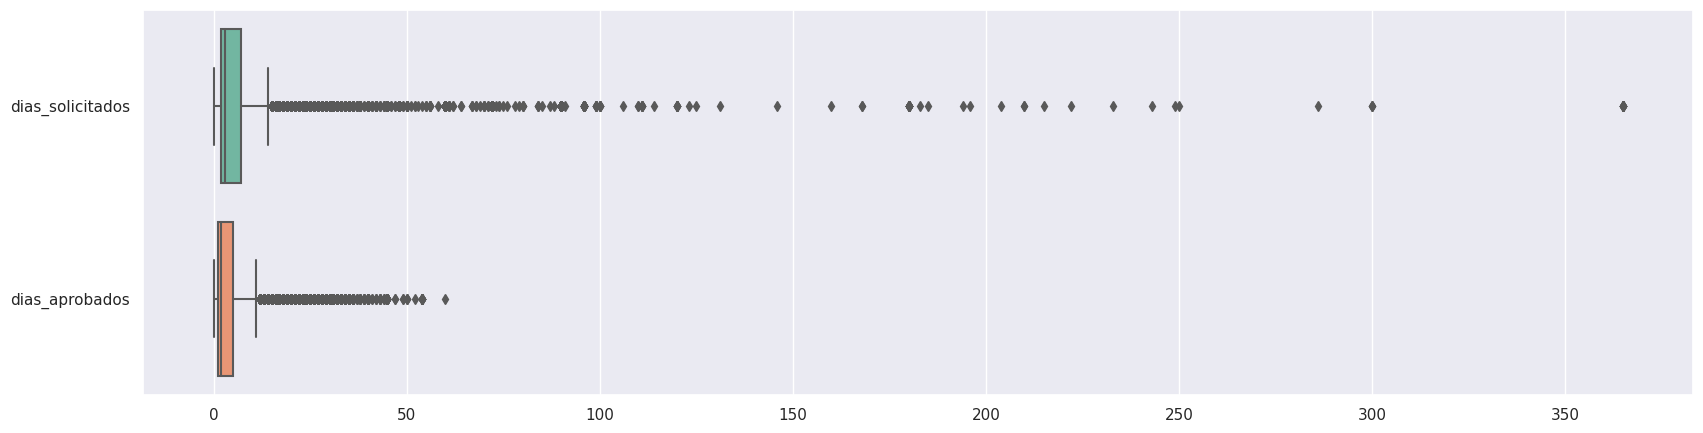

In [22]:
import seaborn as sns

sns.boxplot(relev_df[['dias_solicitados', 'dias_aprobados']], orient="h", palette="Set2")
sns.set(rc={'figure.figsize':(20,5)})

Las distribuciones de las dos variables están sesgadas a la derecha, y si bien hay valores alejados que analíticamente podrían considerarse como atípicos (distancias mayores a 3 veces el rango inter-cuartílico desde el percentil Q3), se desconoce si existe un límite máximo en la cantidad de días de licencia que pueden solicitarse y aprobararse.

> Se detectan valores atípicos (desde el punto de vista analítico)

Sin embargo, luego de consultar con el proveedor de los datos se confirma que son datos posibles en el contexto del problema. 

### c) Imputaciones varias 

#### i) fecha_nacimiento

Se imputarán los valores faltantes con la moda del atributo.

In [23]:
fecha_nacimiento_stats = pd.Series(relev_df['fecha_nacimiento'].to_numpy('datetime64'))

relev_df[relev_df['fecha_nacimiento'] < '1955-01-01']['fecha_nacimiento'] = fecha_nacimiento_stats.mode()

#### ii) fecha_inicio

Se imputarán los valores extraños con el valor de la fecha de creación de dichos registros.

In [24]:
# se seleccionan los registros con fechas de inicio extrañas 
#    (se consideran extrañas las fechas menores a seis meses antes a la menor fecha de creacion)
relev_df[relev_df['fecha_inicio'] < '2020-07-01']['fecha_inicio'] = relev_df['fecha_creacion']

#### iii) fecha_fin

Se imputarán los valores extraños con los valores de la fecha de inicio sumados los días aprobados de dichos registros.

In [25]:
fechas_fin_df = pd.to_datetime(relev_df[relev_df['fecha_fin'] < '2021-01-01']['fecha_inicio'])
dias_aprobados_df = pd.to_timedelta(relev_df[relev_df['fecha_fin'] < '2021-01-01']['dias_aprobados'], 'd')

relev_df[relev_df['fecha_fin'] < '2021-01-01']['fecha_fin'] = fechas_fin_df[fechas_fin_df < '2021-01-01'] + dias_aprobados_df

### 3) Reagrupamiento de variables categóricas

#### a.- Variables con pocas categorías 

La variable *genero* no necesita reagrupamientos.

<Axes: xlabel='Genero', ylabel='Count'>

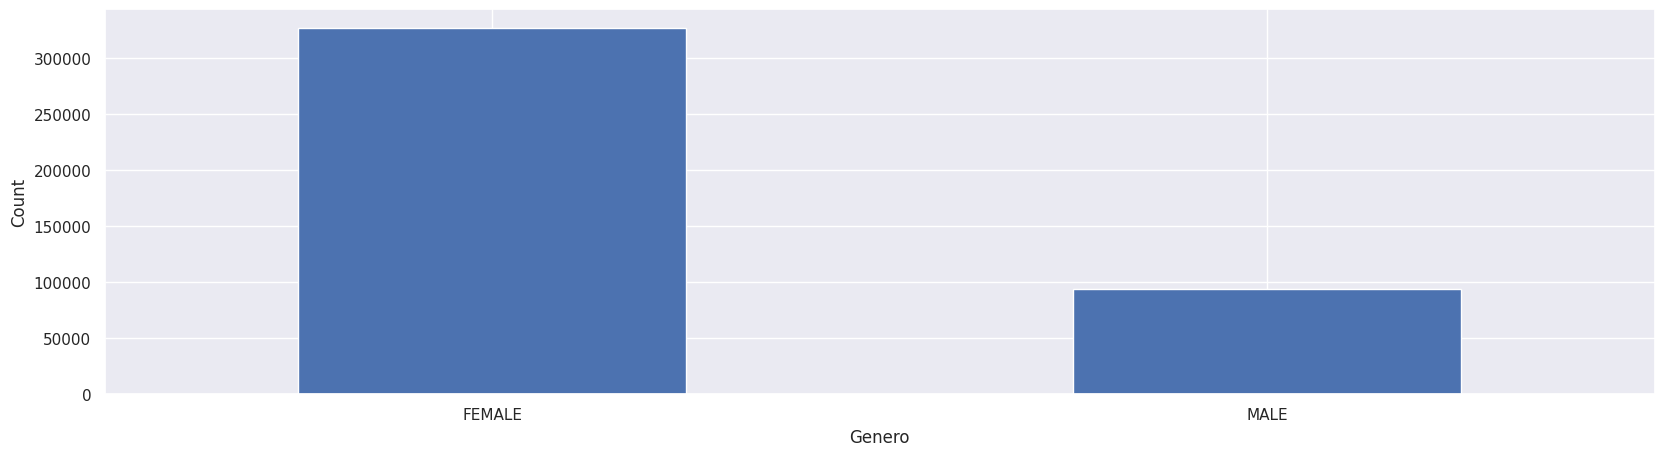

In [26]:
relev_df['genero'].value_counts().plot(kind='bar', xlabel='Genero', ylabel='Count', rot=0)

La variable *tipo_licencia* no necesita reagrupamientos.

<Axes: xlabel='Tipo de licencia', ylabel='Count'>

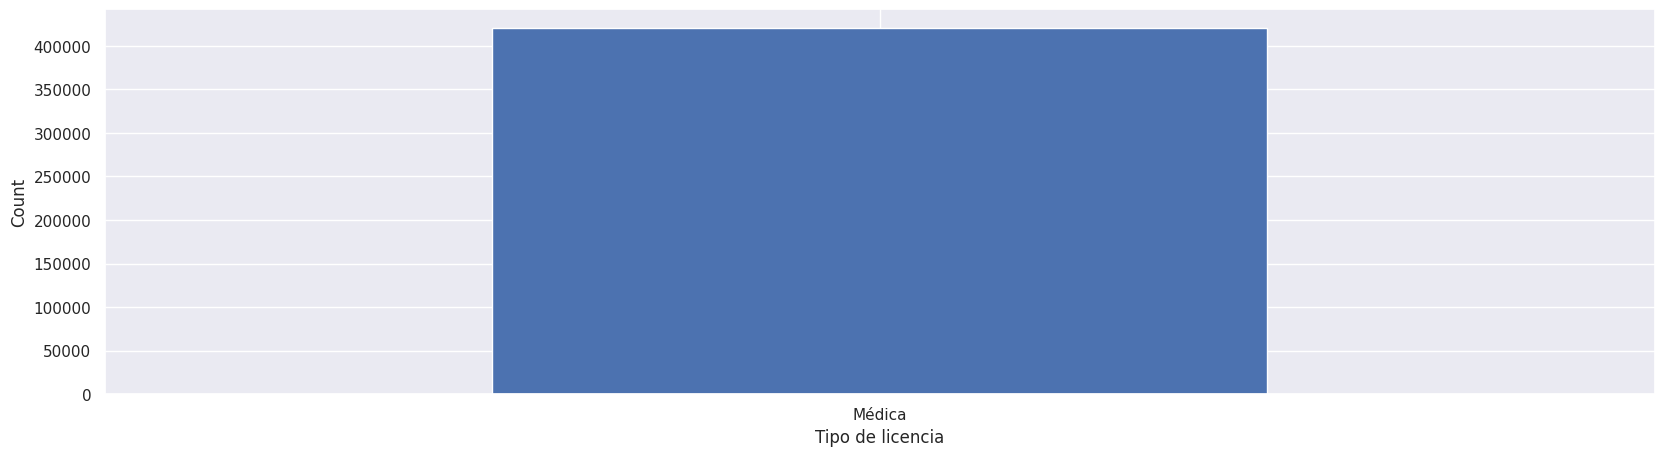

In [27]:

relev_df['tipo_licencia'].value_counts().plot(kind='bar', xlabel='Tipo de licencia', ylabel='Count', rot=0)

La variable *estado_civil* podría reagruparse en las siguientes categorías
 - Soltero
 - Casado
 - Separado
 - Otro

Este reagrupamiento permitiría consolidar categorías con muy baja frecuencia relativa en categorías semánticamente similares.

<Axes: xlabel='Estado Civil', ylabel='Count'>

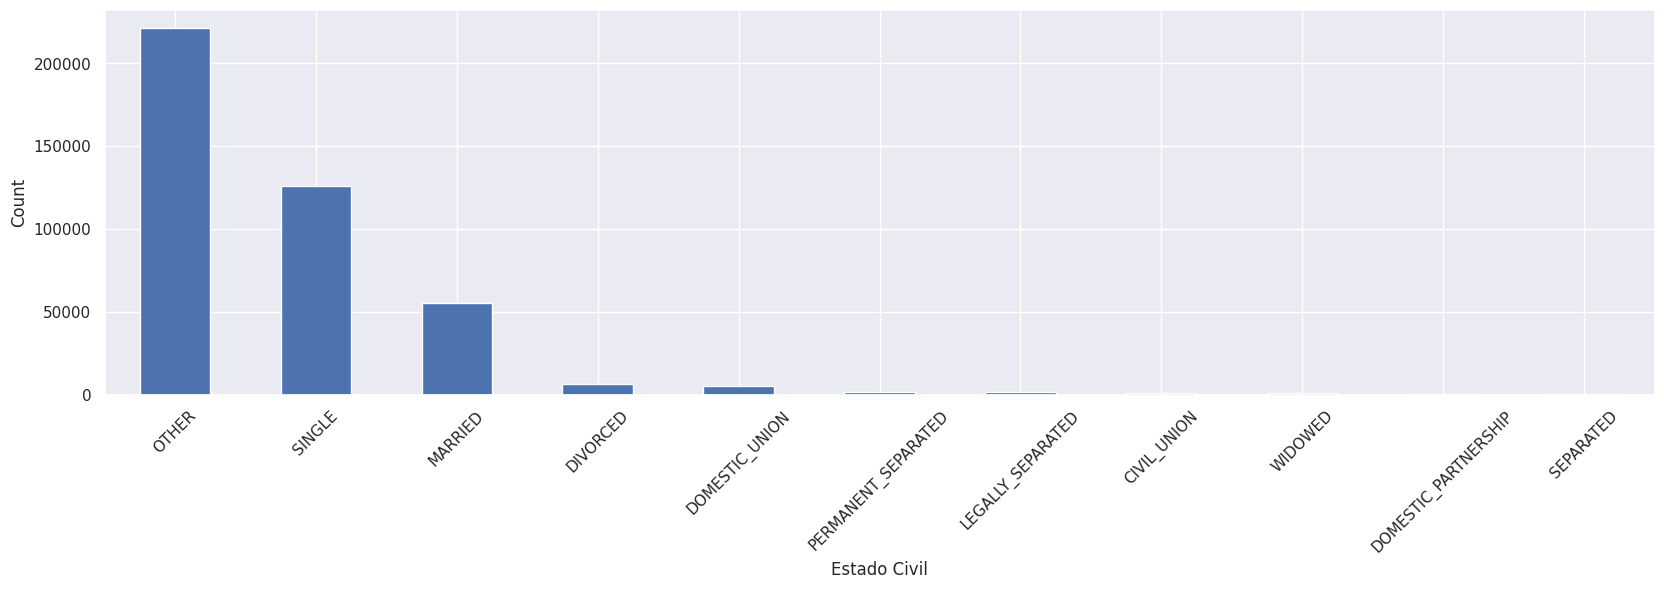

In [28]:
relev_df['estado_civil'].value_counts().plot(kind='bar', xlabel='Estado Civil', ylabel='Count', rot=45)

Luego del reagrupamiento la variable *estado_civil* queda de la siguiente manera

<Axes: xlabel='Estado Civil', ylabel='Count'>

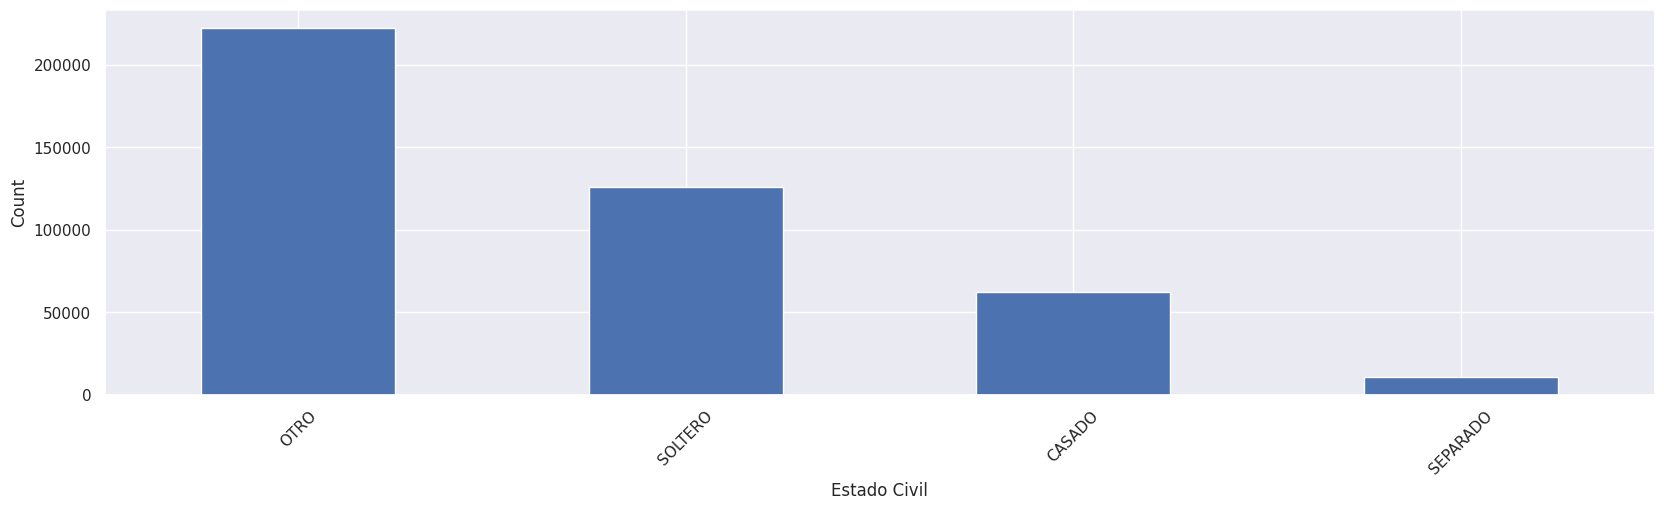

In [29]:
relev_df['estado_civil'] = relev_df['estado_civil'].replace({'OTHER': 'OTRO','SINGLE': 'SOLTERO','MARRIED': 'CASADO','DIVORCED': 'SEPARADO','DOMESTIC_UNION': 'CASADO','PERMANENT_SEPARATED':'SEPARADO','LEGALLY_SEPARATED':'SEPARADO','CIVIL_UNION':'CASADO','WIDOWED':'OTRO','DOMESTIC_PARTNERSHIP':'CASADO','SEPARATED':'SEPARADO'})
relev_df['estado_civil'].value_counts().plot(kind='bar', xlabel='Estado Civil', ylabel='Count', rot=45)

La variable *decision_medica* no necesita reagrupamientos.

<Axes: xlabel='Decision Medica', ylabel='Count'>

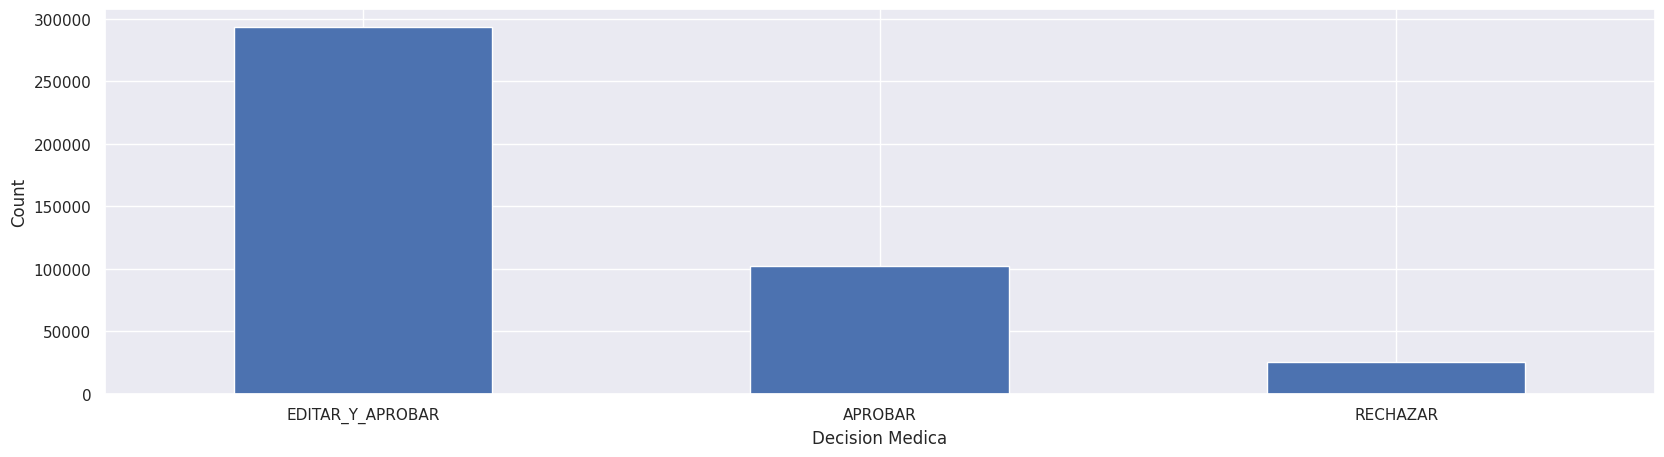

In [30]:
relev_df['decision_medica'].value_counts().plot(kind='bar', xlabel='Decision Medica', ylabel='Count', rot=0)

La variable *motivo_rechazo* podría reagruparse en las siguientes categorías
 - Aprobada
 - Aprobada (menos dias)
 - Rechazada

Este reagrupamiento permitiría consolidar categorías con muy baja frecuencia relativa en categorías semánticamente similares.

<Axes: xlabel='Motivo Rechazo', ylabel='Count'>

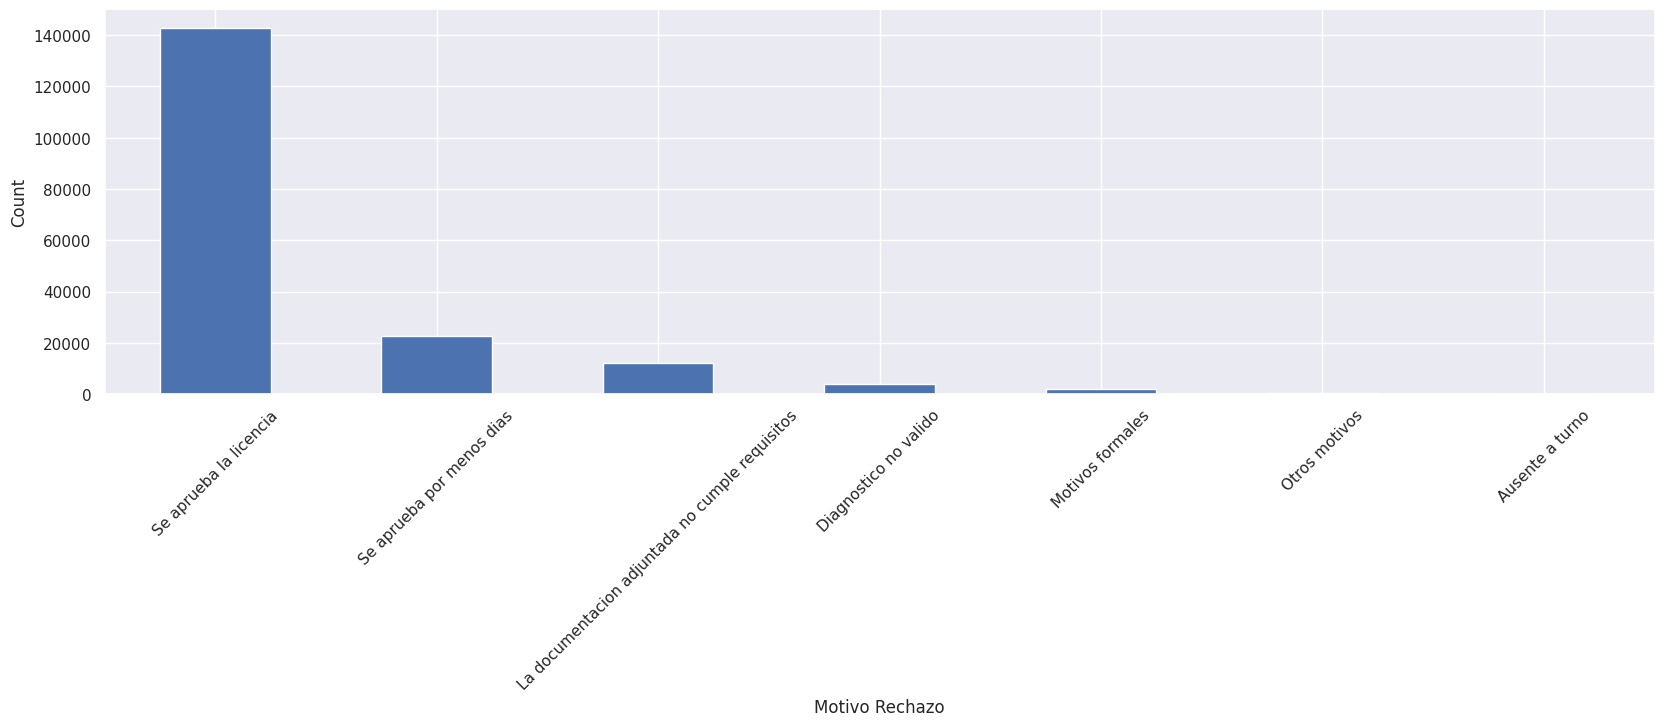

In [31]:
relev_df['motivo_rechazo'].value_counts().plot(kind='bar', xlabel='Motivo Rechazo', ylabel='Count', rot=45)

Luego del reagrupamiento la variable *motivo_rechazo* queda de la siguiente manera

<Axes: xlabel='Motivo Rechazo', ylabel='Count'>

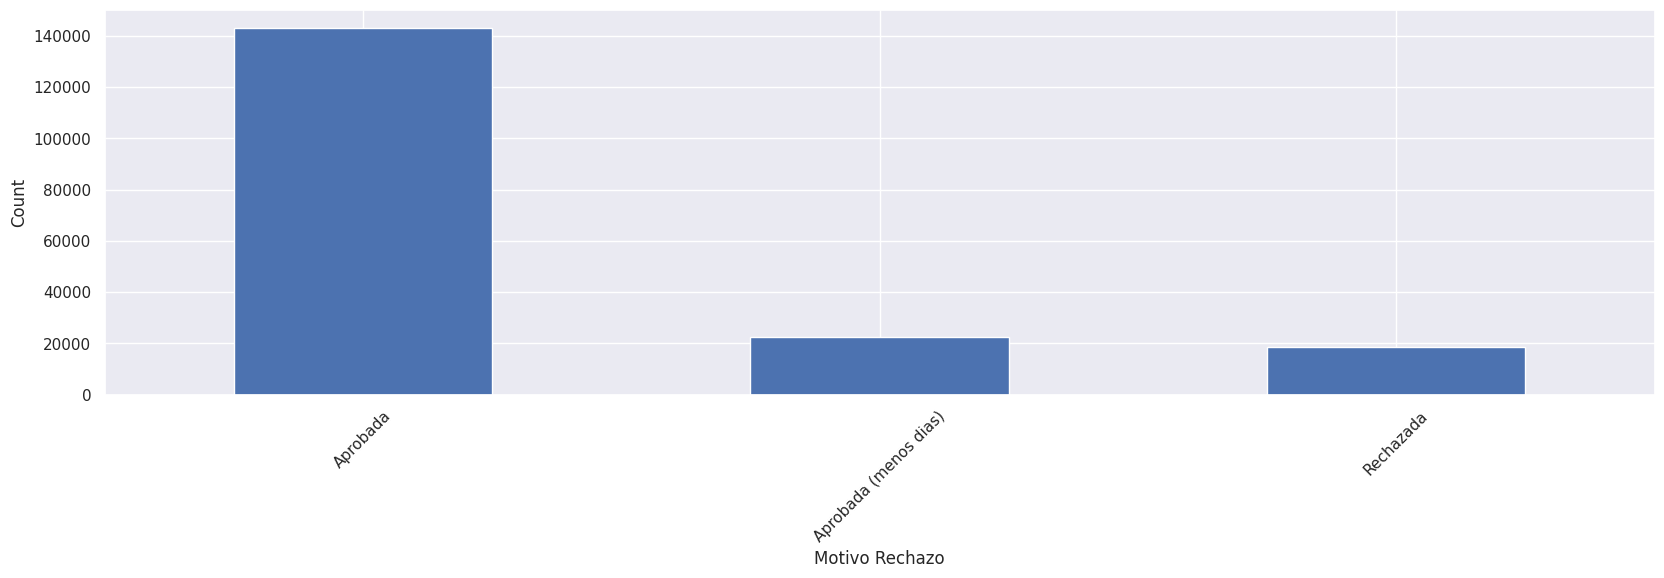

In [32]:
relev_df['motivo_rechazo'] = relev_df['motivo_rechazo'].replace({'Se aprueba la licencia': 'Aprobada','Se aprueba por menos dias': 'Aprobada (menos dias)','La documentacion adjuntada no cumple requisitos': 'Rechazada','Diagnostico no valido': 'Rechazada','Motivos formales': 'Rechazada','Otros motivos':'Rechazada','Ausente a turno':'Rechazada'})
relev_df['motivo_rechazo'].value_counts().plot(kind='bar', xlabel='Motivo Rechazo', ylabel='Count', rot=45)

#### b.- Variables con muchas categorías 

[TO DO]

### 4) Generación de columnas temporales 

A partir de la columna *fecha_creacion* se crearán las siguientes columnas temporales
 - *fecha_creacion_DOY*: número de día en el año 
 - *fecha_creacion_WOY*: número de semana en el año
 - *fecha_creacion_MOY*: número de mes en el año   
 - *fecha_creacion_estacion*: estación en el año   

In [35]:
def get_season(date):
    month = date.month
    day = date.day

    if (month == 12 and day >= 21):
        return 'VERANO'
    if (month > 9) or (month == 9 and day >= 21):
        return 'PRIMAVERA'
    elif (month > 6) or (month == 6 and day >= 21):
        return 'INVIERNO'
    elif (month > 3) or (month == 3 and day >= 21):
        return 'OTOÑO'
    else:
        return 'VERANO'

relev_df["fecha_creacion_DOY"] = relev_df["fecha_creacion"].dt.strftime('%j')
relev_df["fecha_creacion_WOY"] = relev_df["fecha_creacion"].dt.strftime('%W')
relev_df["fecha_creacion_MOY"] = relev_df["fecha_creacion"].dt.strftime('%m')
relev_df['fecha_creacion_estacion'] = relev_df["fecha_creacion"].apply(get_season)

relev_df.head()

,numero_licencia,fecha_creacion,dias_solicitados,fecha_inicio,fecha_fin,diagnostico,id_diagnostico,fecha_nacimiento,genero,tipo_licencia,estado_civil,dias_aprobados,decision_medica,id_auditor,motivo_rechazo,categoria_diagnostico,fecha_creacion_DOY,fecha_creacion_WOY,fecha_creacion_MOY,fecha_creacion_estacion
0,1,2021-01-01 00:10:10.418,2.0,2021-01-01,2021-01-01,EFECTOS ADVERSOS DE VACUNAS VIRALES,33.0,1979-11-28,FEMALE,Médica,OTRO,2.0,EDITAR_Y_APROBAR,14721.0,NaN,CAUSAS EXTREMAS DE MORBILIDAD Y DE MORTALIDAD,001,00,01,VERANO
1,105,2021-01-02 14:14:20.330,2.0,2021-01-02,2021-01-03,EFECTOS ADVERSOS DE VACUNAS VIRALES,33.0,1979-11-08,FEMALE,Médica,OTRO,2.0,EDITAR_Y_APROBAR,14721.0,NaN,CAUSAS EXTREMAS DE MORBILIDAD Y DE MORTALIDAD,002,00,01,VERANO
2,113806,2021-08-26 09:32:09.396,1.0,2021-08-26,2021-08-26,COLELITIASIS,58.0,1980-10-25,FEMALE,Médica,SOLTERO,0.0,RECHAZAR,14721.0,NaN,DIGESTIVO,238,34,08,INVIERNO
3,333787,2022-08-03 20:29:25.519,1.0,2022-08-03,2022-08-03,LUMBAGO NO ESPECIFICADO. CONTRACTURA DORSAL IN...,22.0,1986-12-01,MALE,Médica,SOLTERO,1.0,EDITAR_Y_APROBAR,14721.0,Aprobada,TRAUMATOLOGIA Y ORTOPEDIA,215,31,08,INVIERNO
4,428763,2022-12-26 12:41:18.734,2.0,2022-12-26,2022-12-27,COLITIS Y GASTROENTERITIS NO INFECCIOSAS,6.0,1986-12-21,MALE,Médica,SOLTERO,2.0,EDITAR_Y_APROBAR,14721.0,Aprobada,GASTROINTESTINAL,360,52,12,VERANO


### 5) Generación de archivo a partir de dataset

In [44]:
relev_df.to_csv("licencias_medicas.csv", index=None)
